<a href="https://colab.research.google.com/github/wfwiggins/RSNA-NLP-2020/blob/master/RSNA20_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA 2020: Hands-on AI for Non-Coders**

## **Basics of Information Extraction from Radiology Reports**

In this demonstration, we will utilize techniques of _natural language processing_ (NLP) to train a classifier, which will analyze the text of radiology reports for chest radiographs to predict whether a report is **normal** or **abnormal**.

# System Setup & Downloading the Data

- The first step will install the necessary libraries, then the system will restart. This _WILL_ generate an error message, which can safely be ignored 😉.
- In the second step, we will download the [NLM Open-i "Indiana University Chest X-ray Reports" dataset](https://openi.nlm.nih.gov/faq#collection).

In [ ]:
#@title **Installing libraries & restarting...**

import os

!pip install fastai --upgrade >/dev/null
!pip install xmltodict >/dev/null

os.kill(os.getpid(), 9)

In [1]:
#@title **Downloading the data...**

!curl -s https://openi.nlm.nih.gov/imgs/collections/NLMCXR_reports.tgz | tar xvz >/dev/null

print('Success!')

Success!


# Reformatting the Data

Each of the reports is stored in _extensible markup language_ (XML) format. In order to work with the report text data more easily, we will extract the data and put it into a `pandas.DataFrame`, which is a tabular data structure.

The XML metadata contains [MeSH terms](https://www.ncbi.nlm.nih.gov/mesh/) for each report. We will use these to create the _label_ for each report in our dataset. These labels will serve as the targets for training our classifier to predict whether the report is **normal** or **abnormal**.

In [1]:
#@title **Extracting the data...**

import glob
import xmltodict
from fastai.basics import *

def xml_parse(f):
    with open(f) as xml:
        report_dict = xmltodict.parse(xml.read())
    xml.close()
    return report_dict

def get_label(report):
    label = L(report['eCitation']['MeSH']['major'])
    return 'normal' if label[0].lower() == 'normal' else 'abnormal'

def get_text(report):
    text_dict = {}
    text = report['eCitation']['MedlineCitation']['Article']['Abstract']['AbstractText']
    findings = text[2]['#text'] if '#text' in text[2] else ''
    text_dict['findings'] = findings
    impression = text[3]['#text'] if '#text' in text[3] else ''
    text_dict['impression'] = impression
    text_dict['text'] = ' '.join([findings, impression])
    return text_dict

def process_report(report):
    label = get_label(report)
    report_dict = get_text(report)
    report_dict['label'] = label
    return report_dict

fps = L(glob.glob('/content/ecgen-radiology/*'))
reports = fps.map(xml_parse)
reports_df = pd.DataFrame(reports.map(process_report))
reports_df

,findings,impression,text,label
0,,"Heart size is upper normal. Tortuous and calcified aorta. No edema. Bandlike left base and lingular opacities XXXX scarring or atelectasis. No lobar consolidation, pleural effusion or pneumothorax.","Heart size is upper normal. Tortuous and calcified aorta. No edema. Bandlike left base and lingular opacities XXXX scarring or atelectasis. No lobar consolidation, pleural effusion or pneumothorax.",abnormal
1,The cardiac contours are normal. XXXX scarring left base. The lungs are clear. Thoracic spondylosis.,No acute preoperative process.,The cardiac contours are normal. XXXX scarring left base. The lungs are clear. Thoracic spondylosis. No acute preoperative process.,abnormal
2,There is mild cardiomegaly. The transverse XXXX is calcified. There is a moderate hiatal hernia. The lungs are clear without focal infiltrate. No pleural effusion or pneumothorax. Degenerative changes of the thoracic spine are noted.,1. Mild cardiomegaly and moderate hiatal hernia.,There is mild cardiomegaly. The transverse XXXX is calcified. There is a moderate hiatal hernia. The lungs are clear without focal infiltrate. No pleural effusion or pneumothorax. Degenerative changes of the thoracic spine are noted. 1. Mild cardiomegaly and moderate hiatal hernia.,abnormal
3,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an 8mm nodule identified within the left lateral midlung partially overlying the posterior left 7th rib. There are mild degenerative changes of the spine.",Left midlung pulmonary nodule. Comparison to a previous XXXX would be most helpful alternatively a noncontrast chest CT could be performed in the nonemergent setting for further characterization. No acute disease.,"The heart, pulmonary XXXX and mediastinum are within normal limits. There is no pleural effusion or pneumothorax. There is no focal air space opacity to suggest a pneumonia. There is an 8mm nodule identified within the left lateral midlung partially overlying the posterior left 7th rib. There are mild degenerative changes of the spine. Left midlung pulmonary nodule. Comparison to a previous XXXX would be most helpful alternatively a noncontrast chest CT could be performed in the nonemergent setting for further characterization. No acute disease.",abnormal
4,"The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Normal XXXX.",Negative for acute abnormality.,"The cardiomediastinal silhouette is normal in size and contour. No focal consolidation, pneumothorax or large pleural effusion. Normal XXXX. Negative for acute abnormality.",normal
...,...,...,...,...
3950,"Compared to prior chest radiograph from XXXX, there has been removal of right-sided tunneled dialysis catheter. The cardiomediastinal silhouette is stable and within normal limits for size and contour. Mildly increased atherosclerotic calcifications of the thoracic aorta. 1.0 cm nodular opacity in the left midlung is stable compared to prior examination from XXXX. No XXXX nodules, focal consolidation, or pneumothorax identified. There are XXXX bilateral pleural effusions posteriorly. There is mild central pulmonary vascular congestion without XXXX pulmonary edema. No acute bony abnormality.","Central pulmonary vascular congestion without XXXX edema, consolidation. XXXX bilateral pleural effusions.","Compared to prior chest radiograph from XXXX, there has been removal of right-sided tunneled dialysis catheter. The cardiomediastinal silhouette is stable and within normal limits for size and contour. Mildly increased atherosclerotic calcifications of the thoracic aorta. 1.0 cm nodular opacity in the left midlung is stable compared to prior examination from XXXX. No XXXX nodules, focal consolidation, or pneumothorax identified. There are XXXX bilateral pleural effusions posteriorly. Th

# Exploring the data

As you'll see in the table above, there are some reports where the "Impression" states something along the lines of "No acute cardiopulmonary abnormality" but the label is "abnormal". This is usually due to a chronic incidental finding or artifact that is mentioned in the "Findings", but isn't included in the "Impression".

> We'll revisit this point later when we're deciding which text from the report we want to use to train our classifier.

For now, let's look through a little more of the data and see how many normals and abnormals we have to work with.

In [2]:
#@title **Run this cell several times to view random samples of the data**

reports_df.sample(5)

,findings,impression,text,label
3069,Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen.,1. No evidence of active disease.,Heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. 1. No evidence of active disease.,normal
2287,"Borderline enlarged heart. Pulmonary vasculature appears within normal limits. No focal pulmonary opacity, pleural effusion or pneumothorax. No acute bony abnormality. Possible right shoulder calcific tendinitis. Calcifications of the abdominal aorta are seen.",1. Borderline enlarged heart without acute abnormality.,"Borderline enlarged heart. Pulmonary vasculature appears within normal limits. No focal pulmonary opacity, pleural effusion or pneumothorax. No acute bony abnormality. Possible right shoulder calcific tendinitis. Calcifications of the abdominal aorta are seen. 1. Borderline enlarged heart without acute abnormality.",abnormal
3049,The heart is normal in size. There is bihilar prominence. The lungs are clear.,Bihilar prominence may be secondary mild lymphoid enlargement. Followup chest x-XXXX versus further imaging XXXX may be indicated. Correlation with prior films would be helpful if available.,The heart is normal in size. There is bihilar prominence. The lungs are clear. Bihilar prominence may be secondary mild lymphoid enlargement. Followup chest x-XXXX versus further imaging XXXX may be indicated. Correlation with prior films would be helpful if available.,abnormal
3646,"Right mid lung nodule stable XXXX; etiology not determined. This is noncalcified, and is stable since a CT examination from XXXX and is XXXX benign etiology. The lungs are well inflated and without focal consolidation. The cardiomediastinal silhouette appears unremarkable. Costophrenic XXXX clear. Visualized spine vertebrae appear normal in XXXX and alignment. Overlying leads.",Stable radiographic view of chest.,"Right mid lung nodule stable XXXX; etiology not determined. This is noncalcified, and is stable since a CT examination from XXXX and is XXXX benign etiology. The lungs are well inflated and without focal consolidation. The cardiomediastinal silhouette appears unremarkable. Costophrenic XXXX clear. Visualized spine vertebrae appear normal in XXXX and alignment. Overlying leads. Stable radiographic view of chest.",abnormal
3954,"There is stable prominence of the pulmonary interstitium. XXXX and fluid containing density seen adjacent to the heart is stable, most consistent with a moderate sized hiatal hernia. There is stable tortuosity and/or ectasia of the thoracic aorta, with calcification of the aortic XXXX. No pleural effusion, focal airspace disease or pneumothorax. Stable exaggerated kyphosis of the thoracic spine, stable anterior wedge deformities of at XXXX 2 thoracic vertebral bodies at the apex of the kyphotic curvature. Diffuse osteopenia.",1. No acute pulmonary disease. 2. Stable moderate hiatal hernia.,"There is stable prominence of the pulmonary interstitium. XXXX and fluid containing density seen adjacent to the heart is stable, most consistent with a moderate sized hiatal hernia. There is stable tortuosity and/or ectasia of the thoracic aorta, with calcification of the aortic XXXX. No pleural effusion, focal airspace disease or pneumothorax. Stable exaggerated kyphosis of the thoracic spine, stable anterior wedge deformities of at XXXX 2 thoracic vertebral bodies at the apex of the kyphotic curvature. Diffuse osteopenia. 1. No acute pulmonary disease. 2. Stable moderate hiatal hernia.",abnormal


Here are some of the things you may have noticed about the data, as you reviewed it:
- Some reports only have an Impression (i.e. no separate Findings section)
- Many reports contain blocks of "XXXX" text. This is due to the fact that these reports were anonymized prior to releasing them as an open data set. These blocks likely represent _named entities_ or dates.
- As expected, there is wide variation in the length of these chest radiograph reports.

<hr>

Next, let's count how many of each label we have.


Abnormal: 2564
Normal: 1391



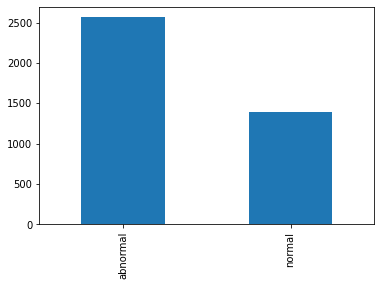

In [3]:
#@title **Label counts: # of Normals & Abnormals**
label_counts = reports_df.label.value_counts()
print('Abnormal:', label_counts['abnormal'])
print('Normal:', label_counts['normal'])
print()
label_counts.plot.bar();

As we see in the bar graph above, there are almost twice as many abnormal reports as there are normal reports. This will be important to remember as we partition our data into training, validation, and test sets.

In fact, we'll go ahead and split off ("hold out") the test set right now to ensure our model is not exposed to it until the very end. 

We'll set it up such that the our test set is 15% of our full data set and keep the relative percentage of labels the same as in our full dataset.

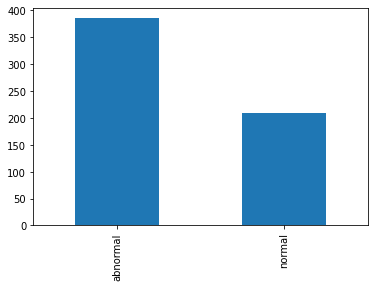

In [4]:
#@title **Test set label counts**
from sklearn.model_selection import train_test_split

np.random.seed(42)

train_val, test = train_test_split(reports_df, test_size=0.15, stratify=reports_df.label.values)
train_val.reset_index(inplace=True)
test.reset_index(inplace=True)
test_counts = test.label.value_counts()
test_counts.plot.bar();

# Language Modeling

The types of algorithms we use in NLP work with with numbers, not text. Therefore, we need a way to convert text into numbers.

## Tokenization

_Tokenization_ is the process by which we split text into chunks or _tokens_. An individual token could be a sentence or phrase, a word, a part of a word, or a single character. Most often, we choose to tokenize at the word or sub-word level.

Each token is assigned a sequential integer value and the collection of token-integer pairs is called our _vocabulary_.

## Embedding

While these integers map one-to-one onto our tokens, their numeric value is otherwise meaningless. To embed more information into the numeric representation of our tokens, we employ a process called _language modeling_. We can either use a pre-trained language model for this _embedding_ or we can fine-tune a language model to better model our "radiology language". This latter process is called _transfer learning_.

In [5]:
#@title **Word Tokenization**

from fastai.text.all import *

spacy = WordTokenizer()
text = train_val.loc[0, 'text']
print('Original text:')
print(text)
print()
tkns = first(spacy([text]))
print('After word tokenization (only showing first 10 tokens):')
print(coll_repr(tkns))

Original text:
Heart size within normal limits. Mild hyperinflation of the lungs. Mild pectus excavatum deformity. Stable left mid lung calcified granuloma. No focal airspace disease. No pneumothorax or effusions. Changes of chronic lung disease with no acute cardiopulmonary finding.

After word tokenization (only showing first 10 tokens):
(#45) ['Heart','size','within','normal','limits','.','Mild','hyperinflation','of','the'...]


In [7]:
#@title **fast.ai Tokenization**

tkn = Tokenizer(spacy)
toks = tkn(text)
print(coll_repr(toks, 15))

(#53) ['xxbos','xxmaj','heart','size','within','normal','limits','.','xxmaj','mild','hyperinflation','of','the','lungs','.'...]


## Added features from fast.ai

You'll notice some odd-appearing tokens in the above output. These are special tokens that indicate certain things about the text.
- `'xxbos'` indicates the beginning of the text _stream_
- `'xxmaj'` indicates that the following character was capitalized before fast.ai lowered it

These special tokens enrich the data while reducing the vocab by eliminating redundant upper and lower case variants of individual words.

## Numericalization

Now that we've converted our text to tokens, the next step in embedding is to convert each unique token to a number.

For language modeling, we can do this on all of the text that we intend to use for training and validation. So we'll combine the **Findings** and **Impression** for each of our reports and tokenize the text to define our _vocabulary_. Each token in the vocabulary will be identified by a unique number.

In [8]:
#@title **Computing vocabulary...**

txts = L(train_val['text'].to_list())
toks = txts.map(tkn)
num = Numericalize()
num.setup(toks)
coll_repr(num.vocab, 20)

"(#1192) ['xxunk','xxpad','xxbos','xxeos','xxfld','xxrep','xxwrep','xxup','xxmaj','.','no','the','is','are','normal',',','4','x','and','of'...]"

As you can see above, we have 1,168 tokens in our vocabulary. The special tokens from `fast.ai` appear first, followed by every other token in order of decreasing frequency. By default, `fast.ai` only includes tokens that appear at least 3 times in the _corpus_ (collection of texts). 

In [9]:
#@title **Numericalizing tokens...**

nums = num(toks[0][:14])
print(nums)
print(' '.join(num.vocab[i] for i in nums))

TensorText([  2,   8,  26,  28,  33,  14,  36,   9,   8,  56, 386,  19,  11,  27])
xxbos xxmaj heart size within normal limits . xxmaj mild hyperinflation of the lungs


Here, we see a subset of the numericalized tokens (top) with their corresponding word tokens (bottom) from the first report in our _corpus_. 

## Language Model Transfer Learning

By default, `fastai.text` uses a language model pre-trained on the WikiText-103 corpus, which is a frequently used benchmark for NLP models, similar to ImageNet for image classification models.

In their 2018 ACL paper "[Universal Language Model Fine-Tuning for Text Classification](https://arxiv.org/abs/1801.06146)", Jeremy Howard and Sebastian Ruder proposed the ULM-FiT approach of fine-tuning the language model on the corpus on which we will train our text classification model.

Here, we will fine-tune the language model in two stages.

In [10]:
#@title **Fine-tuning the language model (part 1)...**

dls_lm = TextDataLoaders.from_df(train_val, valid_pct=0.3, seed=42, text_col='text', is_lm=True)
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()]).to_fp16()
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.634121,2.347184,0.512827,10.456086,00:21


In [11]:
#@title **Fine-tuning the language model (part 2)...**

learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.535172,2.110401,0.552122,8.251551,00:25
1,2.337193,1.888229,0.586144,6.607656,00:24
2,2.152862,1.749690,0.616491,5.752821,00:24
3,1.964617,1.648735,0.636992,5.200397,00:24
4,1.832675,1.570411,0.651443,4.808625,00:24
5,1.719344,1.527669,0.662616,4.607426,00:24
6,1.628574,1.505854,0.667852,4.508002,00:24
7,1.556053,1.494013,0.670273,4.454939,00:24
8,1.494783,1.487383,0.671396,4.425500,00:24
9,1.458480,1.485661,0.671883,4.417885,00:24


In [12]:
#@title **Saving the fine-tuned language model...**

learn.save('fine-tuned')
learn.save_encoder('fine-tuned-enc')

# Language Model Text Generation

Just for fun, let's see how well our language model does at generating text before we move on.

In [11]:
#@title **Download fine-tuned language model**
#@markdown If you've skipped the previous section on fine-tuning the language model, run this cell to download the fine-tuned models from GitHub before proceeding.

!wget -q https://github.com/wfwiggins/RSNA-NLP-2020/blob/master/models.zip?raw=true
!mkdir -p /content/models
!unzip -o models.zip?raw=true -d /content/models >/dev/null
!rm models.zip?raw=true

print('Downloading...')
print('Success!')

Success!


In [13]:
#@title **Text Generator**
#@markdown Enter ~3-5 words to give our language model something to work with, then select other options and run the cell.

text = 'Normal heart size'  #@param {type: "string"}
words_per_sentence = 20     #@param {type: "integer"}
num_sentences = 2        #@param {type: "integer"}

print('Generating predictions...')
learn = learn.load('fine-tuned')
preds = [learn.predict(text, words_per_sentence, temperature=0.75) for _ in range(num_sentences)]
print()
print("\n".join(preds))

Generating predictions...



Normal heart size . Normal mediastinal contours . No pneumothorax , pleural effusion or focal airspace consolidation . Dislocations of
Normal heart size and mediastinal contours . Right hemidiaphragm elevation . No airspace disease . No pleural effusion or pneumothorax


Looks like our generated text is pretty realistic, so there's hope that our language model embeddings will help us to train an accurate report classifier.

# Report Classifier Training

In the steps that follow, we will train a second model as a text classifier, using embeddings from our fine-tuned language model. We will then test the classifier on our held-out test set to see how it performs on data it hasn't seen yet.

In [14]:
#@title **Setting up the Training Experiment**
#@markdown Select options for training, then run the next few cells to train and test your model.
#@markdown Once you've viewed the results, you can come back and run this cell again under different conditions to see how each selection affects model performance.

training_target = 'text'    #@param ["text", "findings", "impression"]
validation_pct = 0.3        #@param {type:"slider", min:0.1, max:0.4, step:0.05}
fine_tuned_LM = True        #@param {type:"boolean"}

dls = TextDataLoaders.from_df(train_val, valid_pct=validation_pct, seed=42, text_col=training_target, label_col='label')
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj chest : 2 images . xxmaj heart size is normal . xxmaj mediastinal contours are maintained . xxmaj there is a mild pectus excavatum deformity . xxmaj the lungs are clear of focal infiltrate . xxmaj there is no evidence for pleural effusion or pneumothorax . xxmaj no convincing acute bony findings . xxmaj right shoulder : 3 images . xxmaj there has been xxrep 4 x and screw fixation of the xxunk right clavicle . xxmaj the lateral most screw is fractured . xxmaj this is age - indeterminate as no prior studies are available for comparison . xxmaj otherwise , the surgical xxrep 4 x appears intact . xxmaj the humeral head is seen within the glenoid , without evidence for dislocation . xxmaj no bony fractures are seen . xxmaj the visualized right ribs appear intact . xxmaj right clavicle : 2 images . xxmaj",abnormal
1,"xxbos xxmaj the heart is mildly enlarged . xxmaj the lungs are hypoinflated with mildly elevated left hemidiaphragm . xxmaj there is patchy opacity in the left lung base which may be secondary to atelectasis and / or possible infiltrate . xxmaj increased markings are noted throughout and were present on prior xxup ct . xxmaj the study is limited secondary to moderate xxrep 4 x motion . xxmaj underlying emphysematous changes are identified . xxmaj hypoinflation with elevated left hemidiaphragm and possible left basilar infiltrate versus atelectasis . xxmaj followup evaluation is suggested in 2 to 4 weeks . xxup xxunk : xxmaj exam : xxup chest xxunk xxup frontal / xxup lateral xxmaj xxunk : xxrep 4 x , xxrep 4 x xxrep 4 x xxup xxunk xxmaj comparison : xxup ct chest xxrep 4 x xxmaj history : xxmaj xxunk of xxunk xxup findings : xxmaj the",abnormal
2,"xxbos xxmaj lungs are hyperinflated with interstitial changes of severe emphysema . xxmaj there is an ill - defined pleural parenchymal opacity in the left upper lobe . xxmaj this may represent scarring but is incompletely evaluated on the outside study , without xxunk and xxunk xxunk . xxmaj there is mild xxrep 4 x scarring and / or atelectasis in the lung bases . xxmaj lungs otherwise grossly clear . xxmaj there is no pneumothorax or pleural effusion . xxmaj heart size is normal . xxmaj there are mild degenerative endplate changes in the thoracic spine . xxmaj there is generalized osteopenia . 1 . xxmaj severe emphysema . 2 . xxmaj irregular , pleural - parenchymal opacity in left upper lobe . xxmaj this may irregular pleural - parenchymal scarring , however , recommend comparison with more remote outside imaging , if available to determine xxunk - xxunk",abnormal


## Iterative Training Process

So that we don't propagate too much error through the network during training, we will train the final layers first, then iteratively _unfreeze_ (i.e. make trainable) a few preceding layers and train a little more before repeating this process.

In [16]:
#@title Training the final layers a little...

learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
if fine_tuned_LM: learn.load_encoder('fine-tuned-enc')
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.735402,0.357298,0.885913,00:09


In [17]:
#@title Unfreezing and training a little more...

learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.570562,0.224237,0.934524,00:11


In [18]:
#@title Unfreezing and training a little more, again...

learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.447646,0.210532,0.931548,00:16


In [19]:
#@title Now let's unfreeze the whole model and finish training.

learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.355540,0.158592,0.948413,00:21
1,0.316223,0.165113,0.947421,00:20
